<Axes: xlabel='DATETIMEDATA'>

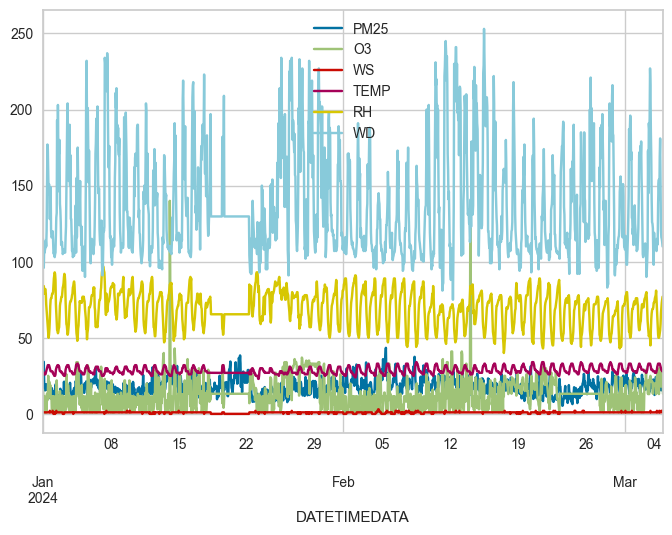

In [19]:
import pandas as pd
data = pd.read_csv('Clean_data2.csv')
data["DATETIMEDATA"] = pd.to_datetime(data["DATETIMEDATA"])
data.set_index('DATETIMEDATA', inplace=True)
data.dropna(inplace=True)
data.head()
data.plot()

In [12]:
data['MA12'] = data['PM25'].rolling(12).mean()

import plotly.express as px
fig = px.line(data.reset_index(), x='DATETIMEDATA', y=['PM25', 'MA12'], template='plotly_dark')
fig.show()
print(data.head())


                     Unnamed: 0  PM25    O3  WS  TEMP  RH   WD  MA12
DATETIMEDATA                                                        
2024-02-19 00:00:00           0  14.4  18.0   1    28  76  108   NaN
2024-02-19 01:00:00           1  17.5  17.0   1    28  76  106   NaN
2024-02-19 02:00:00           2  14.0  18.0   0    28  76  104   NaN
2024-02-19 03:00:00           3  13.6  18.0   1    28  74   96   NaN
2024-02-19 04:00:00           4  14.4  17.0   1    27  78   94   NaN


In [16]:
train = data[data.index < '2024-02-20 00:00:00']
test = data[data.index >= '2024-02-20 00:00:00']


In [8]:

from pycaret.regression import *
s = setup(data = train, test_data = test, target = 'PM25',  fold = 3, transform_target = True, session_id = 123)


NameError: name 'train' is not defined

In [13]:
from pycaret.regression import *
clf = setup(data, target = 'PM25')

,Description,Value
0,Session id,1113
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(33, 8)"
4,Transformed data shape,"(33, 8)"
5,Transformed train set shape,"(23, 8)"
6,Transformed test set shape,"(10, 8)"
7,Numeric features,7
8,Rows with missing values,33.3%
9,Preprocess,True


In [15]:
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.5943,9.0777,2.8006,-0.9074,0.1757,0.1804,0.0060
et,Extra Trees Regressor,2.3602,7.5887,2.6774,-1.2042,0.1595,0.1528,0.0150
omp,Orthogonal Matching Pursuit,2.6840,10.0575,2.9868,-1.6357,0.1798,0.1813,0.0050
llar,Lasso Least Angle Regression,2.6486,10.0438,2.9378,-1.8051,0.1768,0.1771,0.0040
lasso,Lasso Regression,2.6488,10.0444,2.9381,-1.8052,0.1768,0.1771,0.1440
en,Elastic Net,2.6384,10.0330,2.9308,-1.8249,0.1773,0.1769,0.0050
rf,Random Forest Regressor,2.5637,9.2446,2.9527,-1.8357,0.1831,0.1731,0.0160
br,Bayesian Ridge,2.8323,10.6944,3.1274,-1.8812,0.1909,0.1943,0.0040
dummy,Dummy Regressor,3.0472,13.5691,3.5696,-1.9824,0.2238,0.2172,0.0040
lightgbm,Light Gradient Boosting Machine,3.0472,13.5691,3.5696,-1.9824,0.2238,0.2172,0.0070


In [17]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2248,2.0525,1.4327,0.9036,0.0867,0.0859
1,3.4152,17.2758,4.1564,0.1549,0.2140,0.1882
2,3.6115,14.1768,3.7652,-0.9083,0.2117,0.2024
3,2.5086,10.6948,3.2703,-0.2289,0.1762,0.1297
4,2.1217,4.5036,2.1222,0.0695,0.1312,0.1297
5,10.5053,118.5002,10.8858,-25.8708,0.9177,0.6137
6,4.3524,22.0299,4.6936,-33.4218,0.2802,0.3158
7,1.9807,4.2226,2.0549,0.7151,0.1362,0.1454
8,4.5800,27.4843,5.2425,-10.4399,0.3350,0.3860


In [18]:
tuned_lr = tune_model(lr)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7107,0.5192,0.7205,0.9756,0.0497,0.0531
1,3.5229,17.4165,4.1733,0.1480,0.2136,0.1931
2,3.7322,14.9333,3.8644,-1.0102,0.2180,0.2102
3,2.4746,11.7777,3.4319,-0.3534,0.1858,0.1247
4,1.8582,3.5248,1.8774,0.2717,0.1113,0.1118
5,8.0375,67.5483,8.2188,-14.3171,0.5997,0.4730
6,2.6320,7.5576,2.7491,-10.8088,0.1755,0.1922
7,2.2677,5.6864,2.3846,0.6164,0.1565,0.1639
8,4.8768,28.4251,5.3315,-10.8315,0.3398,0.4056


Fitting 10 folds for each of 2 candidates, totalling 20 fits


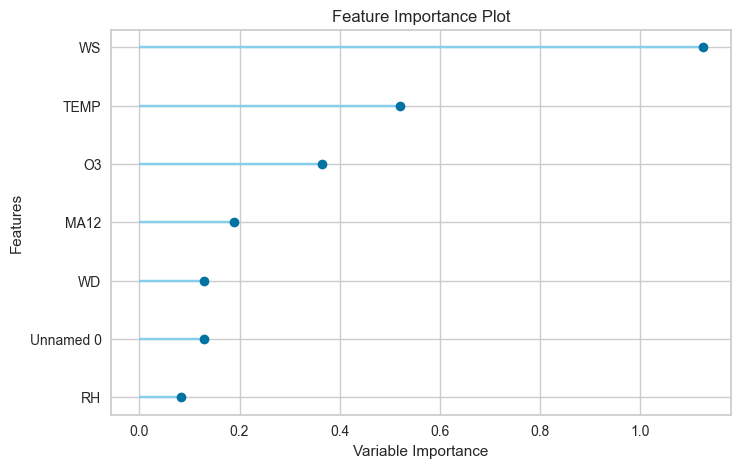

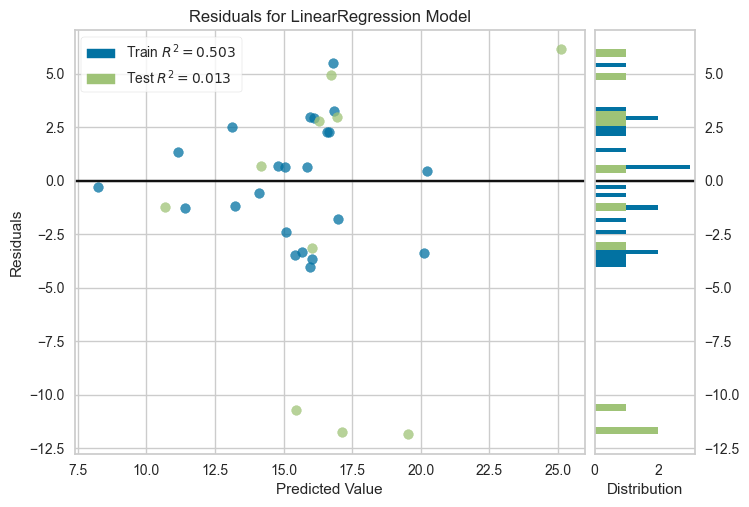

In [20]:
plot_model(tuned_lr, plot='feature')
plot_model(tuned_lr, plot='residuals')

In [37]:
predictions = predict_model(tuned_lr, data=prediction_data)
print(predictions)


                     Unnamed: 0    O3  WS  TEMP  RH   WD       MA12  \
DATETIMEDATA                                                          
2024-02-19 00:00:00           0  18.0   1    28  76  108        NaN   
2024-02-19 01:00:00           1  17.0   1    28  76  106        NaN   
2024-02-19 02:00:00           2  18.0   0    28  76  104        NaN   
2024-02-19 03:00:00           3  18.0   1    28  74   96        NaN   
2024-02-19 04:00:00           4  17.0   1    27  78   94        NaN   
2024-02-19 05:00:00           5  18.0   1    27  78  102        NaN   
2024-02-19 06:00:00           6  15.0   0    27  78  102        NaN   
2024-02-19 07:00:00           7  14.0   1    28  76   96        NaN   
2024-02-19 08:00:00           8  18.0   1    29  71  112        NaN   
2024-02-19 10:00:00          10  22.0   1    31  57  136        NaN   
2024-02-19 11:00:00          11  22.0   1    32  55  147        NaN   
2024-02-19 12:00:00          12  24.0   2    32  55  139  15.158334   
2024-0

In [1]:

import pandas as pd
from pycaret.regression import *
data = pd.read_csv("Clean_data.csv", index_col="Unnamed: 0")
pm25 = data["PM25"]
features = data.drop("PM25", axis=1)
data_prepared = setup(data=features, target=pm25, session_id=123)
best_model = compare_models()
final_model = finalize_model(best_model)
future_features = features.copy()
future_features["DATETIMEDATA"] = pd.date_range(start=data["DATETIMEDATA"].max(), periods=33, freq="D")
predictions = predict_model(final_model, data=future_features)
print(predictions)
predictions.to_csv("P_MLMap.csv", index=False)ฆ

,Description,Value
0,Session id,123
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(33, 7)"
4,Transformed data shape,"(33, 49)"
5,Transformed train set shape,"(23, 49)"
6,Transformed test set shape,"(10, 49)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.1469,20.8586,3.9488,-0.7315,0.2229,0.1873,0.0190
huber,Huber Regressor,3.3600,21.9490,3.8584,-0.7465,0.2218,0.2070,0.0090
en,Elastic Net,3.3387,22.5145,3.8349,-0.8020,0.2208,0.2103,0.0070
lasso,Lasso Regression,3.3918,22.7851,3.8759,-0.8600,0.2230,0.2145,0.1520
llar,Lasso Least Angle Regression,3.3918,22.7851,3.8759,-0.8600,0.2230,0.2145,0.0070
rf,Random Forest Regressor,3.3030,23.0807,3.9713,-0.8796,0.2280,0.1994,0.0190
dummy,Dummy Regressor,3.4476,23.0439,3.9506,-1.2158,0.2271,0.2216,0.0110
br,Bayesian Ridge,3.5568,23.9880,4.0220,-1.2467,0.2316,0.2283,0.0090
ridge,Ridge Regression,3.6628,25.6119,4.2024,-1.2525,0.2393,0.2292,0.0070
omp,Orthogonal Matching Pursuit,3.8246,29.3866,4.5646,-1.3186,0.2657,0.2398,0.0070


                  DATETIMEDATA    O3  WS  TEMP  RH    WD  prediction_label
Unnamed: 0                                                                
0          2024-02-20 09:00:00  18.0   1    28  76   108         14.392000
1          2024-02-21 09:00:00  17.0   1    28  76   106         15.910000
2          2024-02-22 09:00:00  18.0   0    28  76   104         14.191000
3          2024-02-23 09:00:00  18.0   1    28  74    96         14.018000
4          2024-02-24 09:00:00  17.0   1    27  78    94         14.400000
5          2024-02-25 09:00:00  18.0   1    27  78   102         13.306000
6          2024-02-26 09:00:00  15.0   0    27  78   102         13.419000
7          2024-02-27 09:00:00  14.0   1    28  76    96         14.149000
8          2024-02-28 09:00:00  18.0   1    29  71   112         18.978000
10         2024-02-29 09:00:00  22.0   1    31  57   136         13.911000
11         2024-03-01 09:00:00  22.0   1    32  55   147         14.421000
12         2024-03-02 09:

In [7]:
df = pd.read_csv("P_ML2.csv")
df["iso_alpha"] = "THA"

df.to_csv("P_MLMap.csv", index=False)
df

,DATETIMEDATA,prediction_label,iso_alpha
0,2024-03-04 23:00:00,21.416000,THA
1,2024-03-05 23:00:00,21.848000,THA
2,2024-03-06 23:00:00,21.795000,THA
3,2024-03-07 23:00:00,21.817000,THA
4,2024-03-08 23:00:00,21.354000,THA
5,2024-03-09 23:00:00,21.501000,THA
6,2024-03-10 23:00:00,21.538000,THA
7,2024-03-11 23:00:00,21.427000,THA
8,2024-03-12 23:00:00,21.202000,THA
9,2024-03-13 23:00:00,21.351000,THA


In [8]:
df = pd.read_csv("T_ML2.csv")
df["iso_alpha"] = "THA"

df.to_csv("T_MLMap.csv", index=False)
df

,DATETIMEDATA,prediction_label,iso_alpha
0,2024-03-04 23:00:00,28.666546,THA
1,2024-03-05 23:00:00,28.622258,THA
2,2024-03-06 23:00:00,28.758792,THA
3,2024-03-07 23:00:00,28.831448,THA
4,2024-03-08 23:00:00,28.883211,THA
5,2024-03-09 23:00:00,28.635618,THA
6,2024-03-10 23:00:00,28.238952,THA
7,2024-03-11 23:00:00,27.944473,THA
8,2024-03-12 23:00:00,27.891133,THA
9,2024-03-13 23:00:00,27.938866,THA


In [1]:

import pandas as pd
from pycaret.regression import *
data = pd.read_csv("Clean_data.csv", index_col="Unnamed: 0")
pm25 = data["TEMP"]
features = data.drop("TEMP", axis=1)
data_prepared = setup(data=features, target=pm25, session_id=123)
best_model = compare_models()
final_model = finalize_model(best_model)
future_features = features.copy()
future_features["DATETIMEDATA"] = pd.date_range(start=data["DATETIMEDATA"].max(), periods=33, freq="D")
predictions = predict_model(final_model, data=future_features)
print(predictions)
predictions.to_csv("T_ML.csv", index=False)

,Description,Value
0,Session id,123
1,Target,TEMP
2,Target type,Regression
3,Original data shape,"(33, 7)"
4,Transformed data shape,"(33, 49)"
5,Transformed train set shape,"(23, 49)"
6,Transformed test set shape,"(10, 49)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.3247,0.3098,0.4333,0.6480,0.0148,0.0113,0.0120
knn,K Neighbors Regressor,0.3500,0.2527,0.4465,0.6058,0.0151,0.0123,0.0170
rf,Random Forest Regressor,0.3803,0.2791,0.4734,0.6035,0.0161,0.0133,0.0210
lasso,Lasso Regression,0.3433,0.1736,0.3749,0.6001,0.0127,0.0120,0.1590
llar,Lasso Least Angle Regression,0.3433,0.1736,0.3749,0.6001,0.0127,0.0120,0.0090
en,Elastic Net,0.3337,0.1659,0.3673,0.5870,0.0126,0.0117,0.0080
et,Extra Trees Regressor,0.4160,0.2827,0.4811,0.5739,0.0163,0.0145,0.0160
omp,Orthogonal Matching Pursuit,0.3860,0.2419,0.4569,0.2995,0.0156,0.0136,0.0090
gbr,Gradient Boosting Regressor,0.5637,0.4704,0.6471,0.2637,0.0218,0.0196,0.0150
br,Bayesian Ridge,0.3716,0.2426,0.4342,0.2591,0.0148,0.0130,0.0090


                  DATETIMEDATA       PM25    O3  WS  RH    WD  \
Unnamed: 0                                                      
0          2024-02-20 09:00:00  14.400000  18.0   1  76   108   
1          2024-02-21 09:00:00  17.500000  17.0   1  76   106   
2          2024-02-22 09:00:00  14.000000  18.0   0  76   104   
3          2024-02-23 09:00:00  13.600000  18.0   1  74    96   
4          2024-02-24 09:00:00  14.400000  17.0   1  78    94   
5          2024-02-25 09:00:00  13.200000  18.0   1  78   102   
6          2024-02-26 09:00:00  13.500000  15.0   0  78   102   
7          2024-02-27 09:00:00  19.700001  14.0   1  76    96   
8          2024-02-28 09:00:00  19.000000  18.0   1  71   112   
10         2024-02-29 09:00:00  13.500000  22.0   1  57   136   
11         2024-03-01 09:00:00  14.400000  22.0   1  55   147   
12         2024-03-02 09:00:00  14.700000  24.0   2  55   139   
13         2024-03-03 09:00:00  10.600000  23.0   1  52   155   
14         2024-03-04 09:

TEST NEW DATA GOLD

In [21]:

import pandas as pd
from pycaret.regression import *
df = pd.read_csv('gold.csv')
df["Date"] = pd.to_datetime(df["Date"]) 
features = df.drop('Price', axis=1)
price = df['Price']
reg = setup(data=features, target=price, experiment_name='g_p', session_id=123, use_gpu=False, n_jobs=1)
compare_models()
best_model = compare_models()
future_dates = pd.date_range(start=df['Date'].max(), periods=17, freq='Y')
future_df = pd.DataFrame({'Date': future_dates})
predictions = predict_model(best_model, future_df)
print(predictions)


,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(70, 2)"
4,Transformed data shape,"(70, 4)"
5,Transformed train set shape,"(49, 4)"
6,Transformed test set shape,"(21, 4)"
7,Date features,1
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,52.6461,12347.9943,86.4709,0.9016,0.1414,0.0991,0.0500
et,Extra Trees Regressor,47.7843,11168.2320,77.8089,0.8945,0.1227,0.0922,0.0370
gbr,Gradient Boosting Regressor,59.9509,15542.2971,100.0256,0.8700,0.1557,0.1106,0.0270
dt,Decision Tree Regressor,60.2581,15606.7658,100.4382,0.8654,0.1579,0.1104,0.0070
knn,K Neighbors Regressor,55.6805,17451.2992,89.8956,0.8295,0.1693,0.1301,0.0080
ada,AdaBoost Regressor,72.6146,20129.5298,118.7332,0.7870,0.2258,0.1759,0.0240
huber,Huber Regressor,158.6243,67041.3480,214.3619,0.3109,0.6577,1.0289,0.0100
br,Bayesian Ridge,169.6097,54142.0500,210.2821,-0.1719,0.7051,1.3891,0.0120
en,Elastic Net,169.8807,54102.8551,210.4887,-0.1965,0.6999,1.4020,0.0090
llar,Lasso Least Angle Regression,169.9474,54108.7478,210.5403,-0.2003,0.6996,1.4043,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,52.6461,12347.9943,86.4709,0.9016,0.1414,0.0991,0.0520
et,Extra Trees Regressor,47.7843,11168.2320,77.8089,0.8945,0.1227,0.0922,0.0350
gbr,Gradient Boosting Regressor,59.9509,15542.2971,100.0256,0.8700,0.1557,0.1106,0.0270
dt,Decision Tree Regressor,60.2581,15606.7658,100.4382,0.8654,0.1579,0.1104,0.0070
knn,K Neighbors Regressor,55.6805,17451.2992,89.8956,0.8295,0.1693,0.1301,0.0070
ada,AdaBoost Regressor,72.6146,20129.5298,118.7332,0.7870,0.2258,0.1759,0.0230
huber,Huber Regressor,158.6243,67041.3480,214.3619,0.3109,0.6577,1.0289,0.0100
br,Bayesian Ridge,169.6097,54142.0500,210.2821,-0.1719,0.7051,1.3891,0.0070
en,Elastic Net,169.8807,54102.8551,210.4887,-0.1965,0.6999,1.4020,0.0070
llar,Lasso Least Angle Regression,169.9474,54108.7478,210.5403,-0.2003,0.6996,1.4043,0.0070


         Date  prediction_label
0  2019-12-31       1393.896887
1  2020-12-31       1393.896887
2  2021-12-31       1393.896887
3  2022-12-31       1393.896887
4  2023-12-31       1393.896887
5  2024-12-31       1393.896887
6  2025-12-31       1393.896887
7  2026-12-31       1393.896887
8  2027-12-31       1393.896887
9  2028-12-31       1393.896887
10 2029-12-31       1393.896887
11 2030-12-31       1393.896887
12 2031-12-31       1393.896887
13 2032-12-31       1393.896887
14 2033-12-31       1393.896887
15 2034-12-31       1393.896887
16 2035-12-31       1393.896887


NEW DATA SET

In [60]:

import pandas as pd
import numpy as np
from pycaret.regression import *
df = pd.read_csv('air4.csv')
df["DATETIMEDATA"] = pd.to_datetime(df["DATETIMEDATA"]) 
features = df.drop('PM25', axis=1)
price = df['PM25']
reg = setup(data=features, targฆฆet=price, experiment_name='PM25_p', session_id=123, use_gpu=False, n_jobs=1)
compare_models()
best_model = compare_models()
ffuture_dates = pd.date_range(start=df['DATETIMEDATA'].max(), periods=30, freq='D')
future_df = pd.DataFrame({'DATETIMEDATA': future_dates})
future_df['O3'] = np.nan
future_df['WS'] = np.nan
future_df['TEMP'] = np.nan
future_df['RH'] = np.nan
future_df['WD'] = np.nan
future_df.fillna(method='ffill', inplace=True)
predictions = predict_model(best_model, future_df)
predictions=predictions.drop(['O3', 'WS', 'TEMP', 'RH', 'WD'], axis=1)
print(predictions)
predictions.to_csv("P_ML2.csv", index=False)

,Description,Value
0,Session id,123
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(1536, 7)"
4,Transformed data shape,"(1536, 9)"
5,Transformed train set shape,"(1075, 9)"
6,Transformed test set shape,"(461, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,3.1481,17.3027,4.1409,0.3544,0.2169,0.1893,0.2230
et,Extra Trees Regressor,3.1089,17.6496,4.1829,0.3391,0.2161,0.1847,0.1540
lightgbm,Light Gradient Boosting Machine,3.2182,18.1982,4.2504,0.3151,0.2212,0.1915,0.0380
gbr,Gradient Boosting Regressor,3.3123,18.6187,4.2933,0.3074,0.2265,0.2000,0.0830
ada,AdaBoost Regressor,3.7984,23.0076,4.7839,0.1409,0.2583,0.2425,0.0390
lr,Linear Regression,3.8038,23.9395,4.8729,0.1137,0.2603,0.2347,0.0170
ridge,Ridge Regression,3.8038,23.9393,4.8729,0.1137,0.2603,0.2347,0.0150
br,Bayesian Ridge,3.8065,23.9586,4.8742,0.1137,0.2604,0.2351,0.0150
lar,Least Angle Regression,3.8200,24.0569,4.8858,0.1083,0.2609,0.2353,0.0140
huber,Huber Regressor,3.8062,24.2391,4.8996,0.1065,0.2591,0.2305,0.0260


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,3.1481,17.3027,4.1409,0.3544,0.2169,0.1893,0.2270
et,Extra Trees Regressor,3.1089,17.6496,4.1829,0.3391,0.2161,0.1847,0.1590
lightgbm,Light Gradient Boosting Machine,3.2182,18.1982,4.2504,0.3151,0.2212,0.1915,0.0360
gbr,Gradient Boosting Regressor,3.3123,18.6187,4.2933,0.3074,0.2265,0.2000,0.0830
ada,AdaBoost Regressor,3.7984,23.0076,4.7839,0.1409,0.2583,0.2425,0.0390
lr,Linear Regression,3.8038,23.9395,4.8729,0.1137,0.2603,0.2347,0.0140
ridge,Ridge Regression,3.8038,23.9393,4.8729,0.1137,0.2603,0.2347,0.0140
br,Bayesian Ridge,3.8065,23.9586,4.8742,0.1137,0.2604,0.2351,0.0150
lar,Least Angle Regression,3.8200,24.0569,4.8858,0.1083,0.2609,0.2353,0.0140
huber,Huber Regressor,3.8062,24.2391,4.8996,0.1065,0.2591,0.2305,0.0250


          DATETIMEDATA  prediction_label
0  2024-03-04 23:00:00         21.416000
1  2024-03-05 23:00:00         21.848000
2  2024-03-06 23:00:00         21.795000
3  2024-03-07 23:00:00         21.817000
4  2024-03-08 23:00:00         21.354000
5  2024-03-09 23:00:00         21.501000
6  2024-03-10 23:00:00         21.538000
7  2024-03-11 23:00:00         21.427000
8  2024-03-12 23:00:00         21.202000
9  2024-03-13 23:00:00         21.351000
10 2024-03-14 23:00:00         21.479000
11 2024-03-15 23:00:00         20.638000
12 2024-03-16 23:00:00         20.695000
13 2024-03-17 23:00:00         20.391000
14 2024-03-18 23:00:00         19.942000
15 2024-03-19 23:00:00         16.860123
16 2024-03-20 23:00:00         17.125121


In [5]:

import pandas as pd
import numpy as np
from pycaret.regression import *
df = pd.read_csv('air4.csv')
df["DATETIMEDATA"] = pd.to_datetime(df["DATETIMEDATA"]) 
features = df.drop('TEMP', axis=1)
price = df['TEMP']
reg = setup(data=features, target=price, experiment_name='TEMP_P', session_id=123, use_gpu=False, n_jobs=1)
compare_models()
best_model = compare_models()
ffuture_dates = pd.date_range(start=df['DATETIMEDATA'].max(), periods=30, freq='D')
future_df = pd.DataFrame({'DATETIMEDATA': future_dates})
future_df['O3'] = np.nan
future_df['WS'] = np.nan
future_df['PM25'] = np.nan
future_df['RH'] = np.nan
future_df['WD'] = np.nan
future_df.fillna(method='ffill', inplace=True)
predictions = predict_model(best_model, future_df)
predictions=predictions.drop(['O3', 'WS', 'PM25', 'RH', 'WD'], axis=1)
print(predictions)
predictions.to_csv("t_ML2.csv", index=False)

,Description,Value
0,Session id,123
1,Target,TEMP
2,Target type,Regression
3,Original data shape,"(1536, 7)"
4,Transformed data shape,"(1536, 9)"
5,Transformed train set shape,"(1075, 9)"
6,Transformed test set shape,"(461, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4346,0.3384,0.5786,0.9316,0.0198,0.0153,0.0370
gbr,Gradient Boosting Regressor,0.4462,0.3502,0.5891,0.9293,0.0202,0.0157,0.0910
et,Extra Trees Regressor,0.4303,0.3505,0.5889,0.9293,0.0201,0.0151,0.1210
rf,Random Forest Regressor,0.4401,0.3621,0.5992,0.9272,0.0205,0.0155,0.1900
ada,AdaBoost Regressor,0.6210,0.5903,0.7669,0.8819,0.0264,0.0220,0.0660
lr,Linear Regression,0.6348,0.6197,0.7861,0.8768,0.0269,0.0224,0.0150
ridge,Ridge Regression,0.6348,0.6197,0.7861,0.8768,0.0269,0.0224,0.0160
lar,Least Angle Regression,0.6348,0.6197,0.7861,0.8768,0.0269,0.0224,0.0140
br,Bayesian Ridge,0.6348,0.6200,0.7863,0.8767,0.0269,0.0224,0.0140
knn,K Neighbors Regressor,0.5802,0.6174,0.7821,0.8762,0.0265,0.0203,0.0180


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4346,0.3384,0.5786,0.9316,0.0198,0.0153,0.0380
gbr,Gradient Boosting Regressor,0.4462,0.3502,0.5891,0.9293,0.0202,0.0157,0.0910
et,Extra Trees Regressor,0.4303,0.3505,0.5889,0.9293,0.0201,0.0151,0.1170
rf,Random Forest Regressor,0.4401,0.3621,0.5992,0.9272,0.0205,0.0155,0.2000
ada,AdaBoost Regressor,0.6210,0.5903,0.7669,0.8819,0.0264,0.0220,0.0700
lr,Linear Regression,0.6348,0.6197,0.7861,0.8768,0.0269,0.0224,0.0160
ridge,Ridge Regression,0.6348,0.6197,0.7861,0.8768,0.0269,0.0224,0.0150
lar,Least Angle Regression,0.6348,0.6197,0.7861,0.8768,0.0269,0.0224,0.0140
br,Bayesian Ridge,0.6348,0.6200,0.7863,0.8767,0.0269,0.0224,0.0150
knn,K Neighbors Regressor,0.5802,0.6174,0.7821,0.8762,0.0265,0.0203,0.0150


          DATETIMEDATA  prediction_label
0  2024-03-04 23:00:00         28.666546
1  2024-03-05 23:00:00         28.622258
2  2024-03-06 23:00:00         28.758792
3  2024-03-07 23:00:00         28.831448
4  2024-03-08 23:00:00         28.883211
5  2024-03-09 23:00:00         28.635618
6  2024-03-10 23:00:00         28.238952
7  2024-03-11 23:00:00         27.944473
8  2024-03-12 23:00:00         27.891133
9  2024-03-13 23:00:00         27.938866
10 2024-03-14 23:00:00         28.218040
11 2024-03-15 23:00:00         28.376525
12 2024-03-16 23:00:00         28.527380
13 2024-03-17 23:00:00         28.261537
14 2024-03-18 23:00:00         28.670415
15 2024-03-19 23:00:00         28.756109
16 2024-03-20 23:00:00         28.800324
17 2024-03-21 23:00:00         28.800324
18 2024-03-22 23:00:00         28.759192
19 2024-03-23 23:00:00         28.643343
20 2024-03-24 23:00:00         28.875375
21 2024-03-25 23:00:00         28.863334
22 2024-03-26 23:00:00         28.898122
23 2024-03-27 23